# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

**Задача**: построить модель, которая по фотографии определит возраст человека.\
**Критерий успеха**: MAE менее 8.

## Исследовательский анализ данных

В распоряжении набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

Имеем датафрейм с выборкой из 7591 строк, в столбцах которого содержится имя файла и реальный возраст.

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


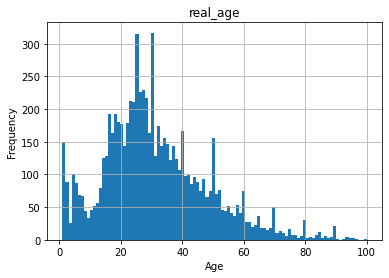

In [5]:
labels['real_age'].plot(kind='hist',bins=100, xlabel='Age', grid=True)
plt.title('real_age')
plt.xlabel('Age')
plt.show()

75% квантиль составляет возраст 41 год. Минимальный возраст 1 год, максимальный 100. Медиана 29 лет.

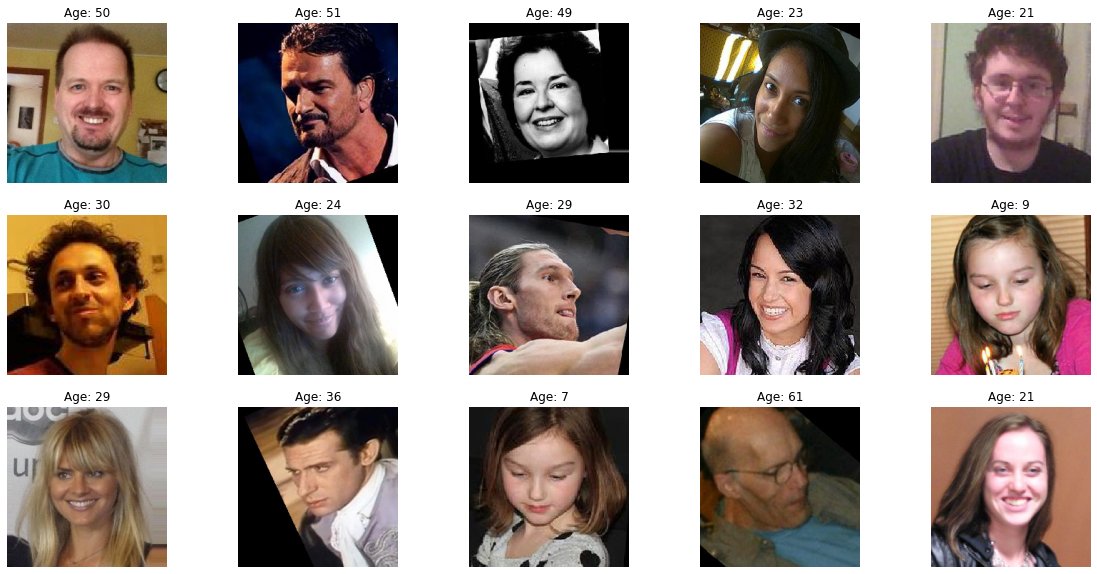

In [6]:
plt.figure(figsize=(20, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    batch = train_gen_flow.next()
    image = batch[0][0]
    label = batch[1][0]
    plt.imshow(image)
    plt.title(f'Age: {label}')
    plt.axis('off')
plt.show()

Некоторые изображения имеют смещение и ротацию.

## Обучение модели


(Код в этом разделе запускается в отдельном GPU-сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels_df = pd.read_csv(path + 'labels.csv')
    image_generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
    train_gen_flow = image_generator.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels_df = pd.read_csv(path + 'labels.csv')
    image_generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
    test_gen_flow = image_generator.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0002)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_data=test_data,
              validation_steps=validation_steps,
              batch_size=batch_size,
              verbose=2)

    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/7
2024-04-15 16:03:55.539366: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-15 16:03:55.869104: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 64s - loss: 183.9865 - mae: 9.9142 - val_loss: 710.8823 - val_mae: 21.5820
Epoch 2/7
190/190 - 37s - loss: 67.3653 - mae: 6.2509 - val_loss: 679.7320 - val_mae: 20.9755
Epoch 3/7
190/190 - 37s - loss: 36.2087 - mae: 4.6163 - val_loss: 366.0272 - val_mae: 14.1941
Epoch 4/7
190/190 - 38s - loss: 24.8239 - mae: 3.8433 - val_loss: 121.6824 - val_mae: 8.2224
Epoch 5/7
190/190 - 38s - loss: 18.3292 - mae: 3.3101 - val_loss: 72.7486 - val_mae: 6.4337
Epoch 6/7
190/190 - 37s - loss: 13.0690 - mae: 2.7826 - val_loss: 64.6143 - val_mae: 6.1218
Epoch 7/7
190/190 - 37s - loss: 9.8845 - mae: 2.4011 - val_loss: 61.5644 - val_mae: 5.9953
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 61.5644 - mae: 5.9953
Test MAE: 5.9953

```

## Анализ обученной модели

В данной моделе на базе ResNet50 применялся алгоритм оптимизации Adam с коэффициентом обучения равным 0.0002. Количество эпох 7. После 7 эпохи модель начинает переобучаться, несмотря на снижение функции потерь, MAE на валидации увеличивается. 

С данными гиперпараметрами удалось достигнуть MAE в 5.9953, что достигает критерия успеха менее 8.

